Dynamics of continental accretion
======

This notebook outlines the Underworld model used in the Moresi (2014) paper 'Dynamics of continental accretion'. It reproduces the initial conditions shown in Extended Data Figure 1 and 2 and the numerics required for reproduce Figure 2.

"In order to better understand the behaviour of this ancient plate mar- gin and the growth of the Australian continent, we use three-dimensional (3D) dynamic models of a subducting slab, overriding plate and mantle, building on previous work14–16. The models have a four-layer subduct- ing plate with buoyancy and rheology of each layer pre-calculated from a half-space cooling model of 80 or 120 Myr age, and they include either a weak or a strong viscoplastic overriding plate (Table 1 and Extended Data Figs 1 and 2). The simulations are best understood by viewing movies of the time evolution (Table 1)."

**References**

Moresi, L., P. G. Betts, M. S. Miller, and R. A. Cayley. 2014. “Dynamics of Continental Accretion.” Nature 508 (7495): 245–48. [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

**TODO!!!**
1. Include passive tracer swarms (before gym)
2. checkpoint - confirm restart works (before lunch)
3. send to Raijin (before lunch)
4. do poster after lunch!

In [1]:
import underworld as uw
from underworld import function as fn
from underworld.scaling import units as u
from underworld.scaling import dimensionalise, non_dimensionalise
from underworld.scaling import non_dimensionalise as nd

import math
import glucifer
import numpy as np
import os
import scipy

In [2]:
import model_properties as modprop
import material_properties as matprop

In [3]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

In [4]:
# Scaling
%run moresi-2014-scaling.ipynb
scaling_coefficients

[mass],1.25e+37 kilogram
[length],1000000.0 meter
[temperature],1299.85 kelvin
[time],1.25e+11 second
[substance],1.0 mole


In [5]:
dimensionalise(0.1, u.megapascal)

<Quantity(80.0, 'megapascal')>

In [6]:
non_dimensionalise(100.*u.megapascal)

0.125

**Setup parameters**


In [7]:
xRes = 128 # 32 # 256  
yRes =  48 # 64 # 96
zRes =   8 #48 # 32 # 96
dim = 3

In [8]:
# Domain
boxLength = nd(modprop.boxLength)
boxHeight = nd(modprop.boxHeight)
boxWidth  = nd(modprop.boxWidth)

**Create mesh and finite element variables**

In [9]:
if dim==2:
    elementRes  = (xRes, yRes)
    minCoord    = (0., -nd(boxHeight)) 
    maxCoord    = (nd(boxLength), 0.)
else:
    elementRes  = (xRes, yRes, zRes)
    minCoord    = (0., -nd(boxHeight), 0.) 
    maxCoord    = (nd(boxLength), 0., nd(boxWidth))

mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = elementRes, 
                                 minCoord    = minCoord,
                                 maxCoord    = maxCoord,
                               ) 

In [10]:
velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

**Create a particle swarm**

In [11]:
particlesPerCell = 20
swarm       = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=particlesPerCell )
swarm.populate_using_layout( layout=swarmLayout )

materialIndex = swarm.add_variable( dataType="int", count=1 )
postSoftening = swarm.add_variable( dataType="int", count=1 )  #
postSoftening.data[:] = 0 # initial softening flag to False

**Material Layout**

In [12]:
%run moresi-2014-material-layout.ipynb
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

**Add passive tracers**

In [68]:
# add surface tracers
def tracer_coords(minX, maxX, minZ, maxZ, dim):
    xx = np.linspace(minX, maxX, max(1, int(maxX-minX))*100)
    yy = np.zeros(1)
    zz = np.linspace(minZ, maxZ, max(1, int(maxX-minX))*100)

    size       = len(xx)*len(yy)*len(zz)
    swarmCoord = np.zeros((size, dim))    
    
    for i, x in enumerate(xx):
        for j, y in enumerate(yy):
            for k, z in enumerate(zz):
                particleNumber = i*len(yy)*len(zz) + j*len(zz) + k
                swarmCoord[particleNumber,0]=x
                swarmCoord[particleNumber,1]=y
                swarmCoord[particleNumber,2]=z
    return swarmCoord

In [119]:
# # Over-riding plate particles
tracer_coords_orp  = tracer_coords(nd(backarc_xStart),  nd(slab_xStart),             0., nd(boxWidth), dim)
tracer_coords_slab = tracer_coords(nd(slab_xStart),     nd(bouyStrip_xStart),        0., nd(slab_dz),  dim)
tracer_coords_cont = tracer_coords(nd(craton_xStart),   nd(backarc_xStart),          0., nd(boxWidth),  dim)
tracer_coords_arc  = tracer_coords(nd(ribbon_xStart),   nd(ribbon_xStart+ribbon_dx), 0., nd(ribbon_dz), dim)
tracer_coords_buoy = tracer_coords(nd(bouyStrip_xStart),nd(slab_xStart+slab_dx),     0., nd(slab_dz),  dim)

In [121]:
swarm_orp    = uw.swarm.Swarm( mesh=mesh )
swarm_slab   = uw.swarm.Swarm( mesh=mesh )
swarm_arc    = uw.swarm.Swarm( mesh=mesh )
swarm_cont   = uw.swarm.Swarm( mesh=mesh )
swarm_buoy   = uw.swarm.Swarm( mesh=mesh )

In [122]:
swarmLayout_orp  =  swarm_orp.add_particles_with_coordinates(tracer_coords_orp)
swarmLayout_slab = swarm_slab.add_particles_with_coordinates(tracer_coords_slab)
swarmLayout_arc  =  swarm_arc.add_particles_with_coordinates(tracer_coords_cont)
swarmLayout_cont = swarm_cont.add_particles_with_coordinates(tracer_coords_arc)
swarmLayout_buoy = swarm_buoy.add_particles_with_coordinates(tracer_coords_buoy)

In [148]:
# add grid for vizualisation
grid_orp = swarm_orp.add_variable( dataType="int", count=1 )
grid_orp.data[:] = 0 


In [ ]:
# Set orp grid lines

def grid_line ():
    

grid_conditions = [
                ( grid_line(fn.input(),space, width), 1),
                ( True, -1),
             ] 

grid_orp.data[:] = fn.branching.conditional( grid_conditions ).evaluate(swarm_orp)


In [ ]:
# create mapped behaviour dictionary

on_grid_lines  =  1
 = -1

fn_z = fn.input()[1]
fn_sin = fn.math.sin(8.*np.pi*fn.input()[0])

fn_grid = {  on_grid_lines:fn_z,
            off_grid_lines:fn_sin }


# create function
fn_grid_orp = fn.branching.map( fn_key = grid_orp, 
                               mapping = fn_grid )

**Visualise particle layout**

In [123]:
figsize=(1000,300)


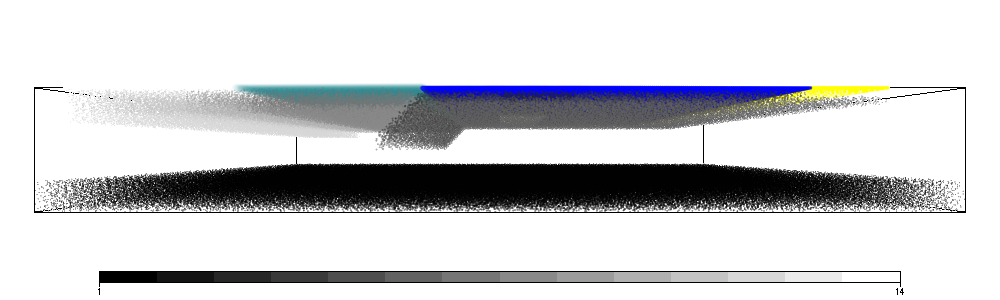

In [146]:
materialFilter = materialIndex > 0
figSwarm = glucifer.Figure(figsize=figsize)

swarmPlot = glucifer.objects.Points(swarm, materialIndex, materialFilter, colours='gray', fn_size=1., discrete=True, opacity=0.5)
figSwarm.append( swarmPlot )

swarm_plot_orp  = glucifer.objects.Points(swarm_orp,  fn_size=4., colours="#22BBBB #225566",  opacity=0.1)
swarm_plot_slab = glucifer.objects.Points(swarm_slab, fn_size=2., colours='blue')
swarm_plot_arc  = glucifer.objects.Points(swarm_arc,  fn_size=2., colours='white')
swarm_plot_cont = glucifer.objects.Points(swarm_cont, fn_size=2., colours='yellow')
swarm_plot_buoy = glucifer.objects.Points(swarm_buoy, fn_size=2., colours='yellow')

figSwarm.append( swarm_plot_orp )
figSwarm.append( swarm_plot_slab )
figSwarm.append( swarm_plot_arc )
figSwarm.append( swarm_plot_cont )
figSwarm.append( swarm_plot_buoy )

figSwarm.show()

In [147]:
if not glucifer.lavavu: raise KeyboardInterrupt #Stop notebook here if no vis enabled
lv = figSwarm.window()
lv.rotate(30)
lv.zoom(-7)
lv.redisplay()
lv.axis()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#np.array([ [0.4,0.2], [0.8,0.4],[1.2,0.6],[1.6,0.8],[3.6,1.8]])

swarmVizORP = uw.swarm.layouts
swarm.populate_using_layout( layout=swarmLayout )

materialIndex = swarm.add_variable( dataType="int", count=1 )

In [ ]:
fn_postSoftening = postSoftening < 1

fn_cohesion_subplate1 = fn.branching.conditional( (
                                 ( fn_postSoftening, nd(matprop.subplate1['cohesion'])),
                                 (             True, nd(matprop.subplate1['cohesion2'])), 
                                                ) )

fn_cohesion_subplate2 = fn.branching.conditional( (
                                 ( fn_postSoftening, nd(matprop.subplate2['cohesion'])),
                                 (             True, nd(matprop.subplate2['cohesion2'])),     
                                                ) )

fn_cohesion_subplate3 = fn.branching.conditional( (
                                 ( fn_postSoftening, nd(matprop.subplate3['cohesion'])),
                                 (             True, nd(matprop.subplate3['cohesion2'])),     
                                                ) )

fn_cohesion_subplate4 = fn.branching.conditional( (
                                 ( fn_postSoftening, nd(matprop.subplate4['cohesion'])),
                                 (             True, nd(matprop.subplate4['cohesion2'])),     
                                                ) )

fn_cohesion_backArc1 = fn.branching.conditional( (
                                 ( fn_postSoftening, nd(matprop.backArc1['cohesion'])),
                                 (             True, nd(matprop.backArc2['cohesion2'])),     
                                                ) )

fn_cohesion_backArc2 = fn.branching.conditional( (
                                 ( fn_postSoftening, nd(matprop.backArc1['cohesion'])),
                                 (             True, nd(matprop.backArc2['cohesion2'])),     
                                                ) )

In [ ]:
cohesionMap = {
                             matprop.um['index'] : nd(matprop.um['cohesion']), 
                             matprop.lm['index'] : nd(matprop.lm['cohesion']), 
                      matprop.subplate1['index'] : fn_cohesion_subplate1, 
                      matprop.subplate2['index'] : fn_cohesion_subplate2, 
                      matprop.subplate3['index'] : fn_cohesion_subplate3, 
                      matprop.subplate4['index'] : fn_cohesion_subplate4, 
                       matprop.backArc1['index'] : fn_cohesion_backArc1, 
                       matprop.backArc2['index'] : fn_cohesion_backArc2, 
                         matprop.trans1['index'] : nd(matprop.trans1['cohesion']), 
                         matprop.trans2['index'] : nd(matprop.trans2['cohesion']), 
                        matprop.craton1['index'] : nd(matprop.craton1['cohesion']), 
                        matprop.craton2['index'] : nd(matprop.craton2['cohesion']), 
                         matprop.ribbon['index'] : nd(matprop.ribbon['cohesion']), 
                      matprop.buoyStrip['index'] : nd(matprop.buoyStrip['cohesion']),    
                    }
cohesionFn = fn.branching.map( fn_key = materialIndex, mapping = cohesionMap )

In [ ]:
figCohesion = glucifer.Figure(figsize=figsize, axis=True)
figCohesion.append( glucifer.objects.Points(swarm, cohesionFn, colours='dem1', fn_size=2., range=[0,0.25]))#, logScale=True) )
figCohesion.show()


In [ ]:
##Set linear viscosity fn
linearViscosityMap = {       matprop.um['index'] : nd(matprop.um['viscosity']), 
                             matprop.lm['index'] : nd(matprop.lm['viscosity']), 
                      matprop.subplate1['index'] : nd(matprop.subplate1['viscosity']), 
                      matprop.subplate2['index'] : nd(matprop.subplate2['viscosity']), 
                      matprop.subplate3['index'] : nd(matprop.subplate3['viscosity']), 
                      matprop.subplate4['index'] : nd(matprop.subplate4['viscosity']), 
                       matprop.backArc1['index'] : nd(matprop.backArc1['viscosity']), 
                       matprop.backArc2['index'] : nd(matprop.backArc2['viscosity']), 
                         matprop.trans1['index'] : nd(matprop.trans1['viscosity']), 
                         matprop.trans2['index'] : nd(matprop.trans2['viscosity']), 
                        matprop.craton1['index'] : nd(matprop.craton1['viscosity']), 
                        matprop.craton2['index'] : nd(matprop.craton2['viscosity']), 
                         matprop.ribbon['index'] : nd(matprop.ribbon['viscosity']), 
                      matprop.buoyStrip['index'] : nd(matprop.buoyStrip['viscosity']),
                    }

linearViscosityFn = fn.branching.map( fn_key = materialIndex, mapping = linearViscosityMap )

In [ ]:
# we are now working in nd viscosity
minViscosity = 1.     
maxViscosity = 1.0e5  

strainRate_2ndInvariant = fn.tensor.second_invariant( fn.tensor.symmetric( velocityField.fn_gradient ))

vonMises    = 0.5 * cohesionFn  / (strainRate_2ndInvariant + 1.0e-18)     
viscosityFn = fn.exception.SafeMaths( fn.misc.max(minViscosity, fn.misc.min(vonMises, linearViscosityFn) ))


In [ ]:
figViscosity = glucifer.Figure(figsize=figsize, axis=True)
figViscosity.append( glucifer.objects.Points(swarm, viscosityFn, colours='dem1', fn_size=2., logScale=True) )
figViscosity.show()

**Eclogite transition**

Assume that the oceanic crust transforms instantaneously and completely to eclogite at a depth of 150 km

In [ ]:
below_150km = fn.input()[1] < nd(-150.*u.kilometers)
fn_conditional = fn.branching.conditional( (
                                              ( below_150km, matprop.subplate1['density2'].magnitude),
                                              (        True, matprop.subplate1['density' ].magnitude), 
                                           ) )


**Define density** 

In [ ]:
#Set density fn
rhoMap = {
                             matprop.um['index'] : matprop.um['density'].magnitude, 
                             matprop.lm['index'] : matprop.lm['density'].magnitude, 
                      matprop.subplate1['index'] : fn_conditional,
                      matprop.subplate2['index'] : matprop.subplate2['density'].magnitude, 
                      matprop.subplate3['index'] : matprop.subplate3['density'].magnitude, 
                      matprop.subplate4['index'] : matprop.subplate4['density'].magnitude, 
                       matprop.backArc1['index'] : matprop.backArc1['density'].magnitude, 
                       matprop.backArc2['index'] : matprop.backArc2['density'].magnitude, 
                         matprop.trans1['index'] : matprop.trans1['density'].magnitude, 
                         matprop.trans2['index'] : matprop.trans2['density'].magnitude, 
                        matprop.craton1['index'] : matprop.craton1['density'].magnitude, 
                        matprop.craton2['index'] : matprop.craton2['density'].magnitude, 
                         matprop.ribbon['index'] : matprop.ribbon['density'].magnitude, 
                      matprop.buoyStrip['index'] : matprop.buoyStrip['density'].magnitude,
                    }

rhoFn = fn.branching.map( fn_key = materialIndex, mapping = rhoMap )

In [ ]:
# note rhoFn value is in kg.m**3, just the magnitude
densityFn = (rhoFn-matprop.ref_density.magnitude) / matprop.ref_density.magnitude

In [ ]:
figDensity = glucifer.Figure(figsize=figsize)
figDensity.append( glucifer.objects.Points(swarm, densityFn, colours='dem1'))
figDensity.show()

**Set the density function, vertical unit vector and Buoyancy Force function**


In [ ]:
# Define our vertical unit vector using a python tuple
if dim == 2:
    z_hat = ( 0.0, 1.0)
else:
    z_hat = ( 0.0, 1.0, 0.0 )    

# now create a buoyancy force vector
buoyancyFn = -densityFn * z_hat

**Set initial and boundary conditions**

In [ ]:
# set initial conditions (and boundary values)
if dim==2:
    velocityField.data[:] = [0.,0.]
else:
    velocityField.data[:] = [0.,0.,0.]
pressureField.data[:] = 0.

# send boundary condition information to underworld
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
if dim==2:
    freeSlipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                   indexSetsPerDof = ( iWalls, jWalls) ) 
    
if dim==3:
    kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]    
    freeSlipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                   indexSetsPerDof = ( iWalls, jWalls, kWalls) ) 

**System Setup**

In [ ]:
# Initial linear slab viscosity setup
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = freeSlipBC,
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = buoyancyFn )
# Create solver & solve
solver = uw.systems.Solver(stokes)

In [ ]:
# use "lu" direct solve if running in serial
if(uw.nProcs==1):
    solver.set_inner_method("lu")

In [ ]:
advector  = uw.systems.SwarmAdvector( swarm=swarm,      velocityField=velocityField, order=2 )
advector2 = uw.systems.SwarmAdvector( swarm=swarm_orp,  velocityField=velocityField, order=2 )
advector3 = uw.systems.SwarmAdvector( swarm=swarm_slab, velocityField=velocityField, order=2 )
advector4 = uw.systems.SwarmAdvector( swarm=swarm_arc,  velocityField=velocityField, order=2 )
advector5 = uw.systems.SwarmAdvector( swarm=swarm_cont, velocityField=velocityField, order=2 )
advector6 = uw.systems.SwarmAdvector( swarm=swarm_buoy, velocityField=velocityField, order=2 )

**Analysis tools**

In [ ]:
#The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )

In [ ]:
figSwarm.append(glucifer.objects.VectorArrows(mesh, velocityField))
figViscosity.append(glucifer.objects.VectorArrows(mesh, velocityField))

**Checkpoint**

In [ ]:
# save mesh
meshHnd = mesh.save(outputPath+'mesh.h5')

In [ ]:
#swarm.save(filename='./swarm.h5')
step = 0
swarmHnd        = swarm.save(        outputPath+'swarm.'       + str(step).zfill(5) +'.h5')

In [ ]:
   # define checkpointing file
def checkpoint():
    # save swarms
    swarmHnd      = swarm.save(     outputPath+'swarm.'     + str(step).zfill(5) +'.h5')
    swarmHnd_orp  = swarm_orp.save( outputPath+'swarm_orp.' + str(step).zfill(5) +'.h5')
    swarmHnd_slab = swarm_slab.save(outputPath+'swarm_slab.'+ str(step).zfill(5) +'.h5')
    swarmHnd_arc  = swarm_arc.save( outputPath+'swarm_arc.' + str(step).zfill(5) +'.h5')
    swarmHnd_cont = swarm_cont.save(outputPath+'swarm_cont.'+ str(step).zfill(5) +'.h5')
    swarmHnd_buoy = swarm_buoy.save(outputPath+'swarm_buoy.'+ str(step).zfill(5) +'.h5')

    # save swarm variables
    materialIndexHnd  = materialIndex.save(  outputPath +'materialIndex.'  + str(step).zfill(5) +'.h5')
    gridHnd_orp       = grid_orp.save(       outputPath +'grid_orp.'       + str(step).zfill(5) +'.h5')
    
    # save mesh variable
    velocityHnd = velocityField.save(outputPath+'velocityField.'+ str(step).zfill(5) +'.h5', meshHnd)
    pressureHnd = pressureField.save(outputPath+'pressureField.'+ str(step).zfill(5) +'.h5', meshHnd)

    # and the xdmf files
    velocityField.xdmf(  outputPath+'velocityField.' +str(step).zfill(5)+'.xdmf',velocityHnd,      "velocity",      meshHnd, "mesh", modeltime=time)
    pressureField.xdmf(  outputPath+'pressureField.' +str(step).zfill(5)+'.xdmf',pressureHnd,      "pressure",      meshHnd, "mesh", modeltime=time)
    materialIndex.xdmf(  outputPath+'materialIndex.' +str(step).zfill(5)+'.xdmf',materialIndexHnd, "materialIndex", swarmHnd,"swarm",modeltime=time)
    
    grid_orp.xdmf( outputPath+'grid_orp.' +str(step).zfill(5)+'.xdmf',gridHnd_orp, "grid_ord", swarmHnd_orp,"swarm_orp",modeltime=time)
    


Main simulation loop
=======

The main time stepping loop begins here. Inside the time loop the velocity field is solved for via the Stokes system solver and then the swarm is advected using the advector integrator. Basic statistics are output to screen each timestep.

In [ ]:
time = 0.  # Initial time
step = 0   # Initial timestep
maxSteps = 10      # Maximum timesteps (201 is recommended)
steps_output = 1   # output every 10 timesteps
checkoutput  = 1

In [ ]:
if(uw.rank()==0):
    with open(outputPath+'FrequentOutput.dat','a') as f:
         f.write('step\t time\t time(yr)\t Vrms\t Vrms(cm/yr)\n')

In [ ]:
def update_postSoftening():
    # if yeilded with postSoften==0,
    vonMises_data          = vonMises.evaluate(swarm)
    linearViscosityFn_data = linearViscosityFn.evaluate(swarm)
    for i, x in enumerate(swarm.data[:]):
         if vonMises_data[i] < linearViscosityFn_data[i]:
                #print i, vonMises_data[i], linearViscosityFn_data[i]
                postSoftening.data[i] = 1

In [ ]:
# define an update function
def update():
    update_postSoftening()
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size.
    advector.integrate(dt)
    advector2.integrate(dt)
    advector3.integrate(dt)
    advector4.integrate(dt)
    advector5.integrate(dt)
    advector6.integrate(dt)
    return time+dt, step+1

In [ ]:
solver.set_inner_method('lu')

In [ ]:
while step < maxSteps*1:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)#, print_stats=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        figSwarm.save(    outputPath + "particle"    + str(step).zfill(4))
        figViscosity.save(   outputPath + "viscosity"   + str(step).zfill(4))
        figDensity.save(     outputPath + "density"     + str(step).zfill(4))
        
    Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
    if(uw.rank()==0):
        with open(outputPath+'FrequentOutput.dat','ab') as f:
            np.savetxt(f, np.column_stack((step, time, dimensionalise(time, u.year).magnitude, Vrms, dimensionalise(Vrms, u.centimeter/u.year).magnitude)), fmt='%.8e')
        print('step = {0:6d};\t time = {1:.3e};\t , time(yr) = {2:.3e};\t Vrms = {3:.3e};\t'.format(step, time, dimensionalise(time, u.year).magnitude, Vrms))
    

    if step % checkoutput == 0:
        checkpoint()
    # update
    time,step = update()

In [ ]:
# if not glucifer.lavavu: raise KeyboardInterrupt #Stop notebook here if no vis enabled
# lv = figSwarm.window()
# lv.rotate(30)
# lv.zoom(-7)
# lv.redisplay()
# lv.axis()

In [ ]:
figPostSoftening = glucifer.Figure(figsize=figsize)
figPostSoftening.append( glucifer.objects.Points(swarm, postSoftening, colours='dem1'))
figPostSoftening.show()

In [ ]:
figCohesion.show()

In [ ]:
dimensionalise(time, u.megayear).magnitude

In [ ]:
figViscosity.show()

In [ ]:
figDensity.show()

In [ ]:
while step < maxSteps*10:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)#, print_stats=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        figSwarm.save(    outputPath + "particle"    + str(step).zfill(4))
        figViscosity.save(   outputPath + "viscosity"   + str(step).zfill(4))
        figDensity.save(     outputPath + "density"     + str(step).zfill(4))
        
    Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
    if(uw.rank()==0):
        with open(outputPath+'FrequentOutput.dat','ab') as f:
            np.savetxt(f, np.column_stack((step, time, dimensionalise(time, u.year).magnitude, Vrms, dimensionalise(Vrms, u.centimeter/u.year).magnitude)), fmt='%.8e')
        print('step = {0:6d};\t time = {1:.3e};\t , time(yr) = {2:.3e};\t Vrms = {3:.3e};\t'.format(step, time, dimensionalise(time, u.year).magnitude, Vrms))


    if step % checkoutput == 0:
        checkpoint()
    # update
    time,step = update()

In [ ]:
figSwarm.show()

In [ ]:
figDensity.show()

In [ ]:
materialFilter = materialIndex < 3.1

In [ ]:
# Density change for eclogite.
figFilter = glucifer.Figure(figsize=figsize)
figFilter.append( glucifer.objects.Points(swarm, densityFn, colours='dem1', fn_mask=materialFilter))
figFilter.show()

In [ ]:
figPostSoftening.show()

In [ ]:
figCohesion.show()

In [ ]:
figViscosity.show()

In [ ]:
while step < maxSteps*15:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)#, print_stats=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        figSwarm.save(    outputPath + "particle"    + str(step).zfill(4))
        figViscosity.save(   outputPath + "viscosity"   + str(step).zfill(4))
        figDensity.save(     outputPath + "density"     + str(step).zfill(4))
        
    Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
    if(uw.rank()==0):
        with open(outputPath+'FrequentOutput.dat','ab') as f:
            np.savetxt(f, np.column_stack((step, time, dimensionalise(time, u.year).magnitude, Vrms, dimensionalise(Vrms, u.centimeter/u.year).magnitude)), fmt='%.8e')
        print('step = {0:6d};\t time = {1:.3e};\t , time(yr) = {2:.3e};\t Vrms = {3:.3e};\t'.format(step, time, dimensionalise(time, u.year).magnitude, Vrms))


    if step % checkoutput == 0:
        checkpoint()
    # update
    time,step = update()

In [ ]:
figViscosity.show()

In [ ]:
figSwarm.show()

In [ ]:
TODO - passive tracers, 3D